In [1]:
import pandas as pd

# Inegi

In [2]:
inegi = pd.read_csv('inegi.csv')

In [3]:
inegi['entidad'] = inegi['entidad'].apply(lambda x: 'YUCATAN' if 'YUCA' in x else x)
yinegi = inegi[inegi['entidad']=='YUCATAN']
yinegi.head()

,nom_estab,nombre_act,per_ocu,entidad,municipio,localidad,www,tipoUniEco,latitud,longitud,fecha_alta
152158,100 ARRACHERO,Restaurantes con servicio de preparación de ta...,6 a 10 personas,YUCATAN,Mérida,Mérida,NaN,Fijo,21.001433,-89.605708,2010-07-01
152159,100 MONTADITOS,Restaurantes con servicio de preparación de al...,11 a 30 personas,YUCATAN,Mérida,Mérida,NaN,Fijo,21.038795,-89.601918,2019-11-01
152160,100 NATURAL,"Cafeterías, fuentes de sodas, neverías, refres...",11 a 30 personas,YUCATAN,Mérida,Mérida,NaN,Fijo,21.024276,-89.624382,2010-07-01
152161,100 NATURAL RESTAURANTES,Restaurantes con servicio de preparación de al...,11 a 30 personas,YUCATAN,Mérida,Mérida,WWW.100NATURAL.COM,Fijo,21.020646,-89.585322,2014-12-01
152162,100 PIZZAS,Restaurantes con servicio de preparación de pi...,11 a 30 personas,YUCATAN,Mérida,Mérida,NaN,Fijo,20.998787,-89.566374,2019-11-01


In [4]:
yinegi['localidad'].value_counts()

Mérida                                 7475
Valladolid                              636
Kanasín                                 600
Tizimín                                 529
Ticul                                   483
                                       ... 
San Antonio Millet                        1
El Cuyo                                   1
Montecristo [Inmobiliaria Hotelera]       1
Xcanatún                                  1
Hubikú                                    1
Name: localidad, Length: 157, dtype: int64

In [5]:
yinegi.drop(yinegi[yinegi['localidad']!='Mérida'].index, inplace=True)
yinegi['localidad'].value_counts()

/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Mérida    7475
Name: localidad, dtype: int64

In [6]:
yinegi['nom_estab'].value_counts()

COCINA ECONÓMICA SIN NOMBRE                         96
COCINA ECONÓMICA                                    93
VENTA DE ANTOJITOS                                  75
VENTA DE ANTOJITOS SIN NOMBRE                       65
LONCHERÍA SIN NOMBRE                                46
                                                    ..
COCINA DEL NORTE                                     1
TAQUERIA EN TAQUIZA BY RACHOS                        1
LOS BISQUETS BISQUETS OBREGON NORTE                  1
COCINA ECONÓMICA CLAUDIA MARIBLE MARTIENEZ BALAM     1
PAPA NACHO                                           1
Name: nom_estab, Length: 5910, dtype: int64

## Extracting main food types

In [7]:
import re

def clean_up(s):
    """
    Cleans up numbers, URLs, and special characters from a string.

    Args:
        s: The string to be cleaned up.

    Returns:
        A string that has been cleaned up.
    """
    res = re.sub('[0-9]+', '', s).lower()
    res = re.sub('http://\w+\.\w+', '', res)
    
    for letter in res:
        if not letter.isalpha() and letter != ' ':
            res = res.replace(letter,' ')
            
    #res = re.sub('http', '', res)
    return res.strip()

In [8]:
from nltk.tokenize import word_tokenize

def tokenize(s):
    """
    Tokenize a string.

    Args:
        s: String to be tokenized.

    Returns:
        A list of words as the result of tokenization.
    """
    return word_tokenize(s)

In [9]:
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
#print(" ".join(SnowballStemmer.languages))

def stem_and_lemmatize(l):
    """
    Perform stemming and lemmatization on a list of words.

    Args:
        l: A list of strings.

    Returns:
        A list of strings after being stemmed and lemmatized.
    """
    stemmer = SnowballStemmer('spanish')
    lemmatizer = WordNetLemmatizer()
    
    res = []
    for word in l:
        stem_word = stemmer.stem(word) 
        res.append(lemmatizer.lemmatize(stem_word))
        
    return res

In [10]:
from nltk.corpus import stopwords

def remove_stopwords(l):
    """
    Remove English stopwords from a list of strings.

    Args:
        l: A list of strings.

    Returns:
        A list of strings after stop words are removed.
    """
    stopWords = set(stopwords.words('spanish'))
    return [w for w in l if w not in stopWords]

In [11]:
def prepareText(text):
    cleaned = clean_up(text)
    tokenized = tokenize(cleaned)
    sl_ized = stem_and_lemmatize(tokenized)
    return remove_stopwords(sl_ized)

In [12]:
import multiprocessing as mp

pool = mp.Pool(processes=(mp.cpu_count()-1))

yinegi['nom_processed'] = pool.map(prepareText, yinegi.nom_estab)
yinegi.head()

/home/linuxbrew/.linuxbrew/Cellar/jupyterlab/1.2.4/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,nom_estab,nombre_act,per_ocu,entidad,municipio,localidad,www,tipoUniEco,latitud,longitud,fecha_alta,nom_processed
152158,100 ARRACHERO,Restaurantes con servicio de preparación de ta...,6 a 10 personas,YUCATAN,Mérida,Mérida,NaN,Fijo,21.001433,-89.605708,2010-07-01,[arracher]
152159,100 MONTADITOS,Restaurantes con servicio de preparación de al...,11 a 30 personas,YUCATAN,Mérida,Mérida,NaN,Fijo,21.038795,-89.601918,2019-11-01,[montadit]
152160,100 NATURAL,"Cafeterías, fuentes de sodas, neverías, refres...",11 a 30 personas,YUCATAN,Mérida,Mérida,NaN,Fijo,21.024276,-89.624382,2010-07-01,[natural]
152161,100 NATURAL RESTAURANTES,Restaurantes con servicio de preparación de al...,11 a 30 personas,YUCATAN,Mérida,Mérida,WWW.100NATURAL.COM,Fijo,21.020646,-89.585322,2014-12-01,"[natural, restaur]"
152162,100 PIZZAS,Restaurantes con servicio de preparación de pi...,11 a 30 personas,YUCATAN,Mérida,Mérida,NaN,Fijo,20.998787,-89.566374,2019-11-01,[pizz]


In [13]:
yinegi['tipo'] = yinegi.nom_processed.apply(lambda x: ' '.join(x))

pd.set_option('display.max_rows', None)
yinegi.tipo.value_counts()

/home/linuxbrew/.linuxbrew/Cellar/jupyterlab/1.2.4/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


cocin econom nombr                                                           97
cocin econom                                                                 95
vent antojit                                                                 79
vent antojit nombr                                                           71
lonch nombr                                                                  46
vent panuch salbut                                                           44
lonch                                                                        37
vent com nombr                                                               32
vent panuch                                                                  30
antojit nombr                                                                30
vent cochinit                                                                28
antojit                                                                      27
vent panuch nombr                       

In [14]:
tipos = ['cocin', 'com', 'caser', 'antojit', 'lonch', 'panuch', 'cochinit', 'lechon', 'tamal', 'poll', 'desay', 'pizz', 'tort', 
         'burg', 'taqu', 'tac', 'carne', 'asad', 'carnit', 'mondong', 'empan', 'hot dog', 'hotdog', 'fritang', 'pesc', 'marisc', 'marisq',
         'chicharr', 'gordit', 'cevich', 'costill', 'asader', 'grill', 'carnit', 'sush', 'doradit', 'baguet', 'parrill', 'birr', 'pozole',
         'huarach', 'rosti', 'china', 'chinesse', 'yuca', 'tabas', 'vaporc', 'arracher', 'restaur', 'barbaco', 'pastor']

def getTokenType(text):
    token_type = []
    for tipo in tipos:
        if tipo in text:
            token_type.append(tipo)
            
    return token_type
#for tipo in tipos:
#    yinegi.tipo = yinegi.tipo.apply(lambda x: tipo if tipo in x else x)
 
yinegi.tipo = yinegi.tipo.apply(getTokenType)

yinegi.tipo.value_counts()

/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


[]                                             2267
[cocin]                                        1077
[lonch]                                         482
[taqu]                                          459
[antojit]                                       435
[restaur]                                       371
[pizz]                                          278
[com]                                           181
[panuch]                                        169
[poll]                                          115
[tort]                                          107
[tac]                                           104
[burg]                                          103
[cochinit]                                       90
[desay]                                          79
[tamal]                                          77
[poll, asad]                                     74
[pesc]                                           70
[chicharr]                                       70
[tort, tac] 

In [15]:
foods = {
    'Cocina Económica': ['cocin', 'com', 'caser'],
    'Antojitos': ['antojit', 'lonch', 'cenaduria', 'fritang'],
    'Pizza': ['pizz'],
    'Hamburguesas': ['burg'],
    'Hot Dogs': ['hot dog', 'hotdogs'],
    'Sushi': ['sush'],
    'Tamales': ['tamal', 'vaporc'],
    'Mariscos': ['marisc', 'marisq', 'cevich'],
    'Pescado': ['pesc'],
    'Tacos': ['tac', 'taqu'],
    'Carne': ['carne'],
    'Asada': ['asader', 'asad'],
    'Panuchos': ['panuch', 'salbut'],
    'Cochinita': ['cochinit', 'lechon'],
    'Pollo': ['poll'],
    'Desayunos': ['desay'],
    'Tortas': ['tort'],
    'Mondongo': ['mondong'],
    'Empanadas': ['empan'],
    'Chicharronería': ['chicharr'],
    'Gorditas': ['gordit'],
    'Costillas': ['costill'],
    'Grill': ['grill'],
    'Carnitas': ['carnit'],
    'Doraditas': ['doradit'],
    'Baguettes': ['baguet', 'deli'],
    'Parrilla': ['parrill'],
    'Huaraches': ['huarach'],
    'Rosticería': ['rost'],
    'China': ['china', 'chinesse'],
    'Yucateca': ['yuca'],
    'Tabasqueña': ['tabas'],
    'Arrachera': ['arracher'],
    'Pastor': ['pastor'],
    'Birria': ['birr'],
    'Barbacoa': ['barbac'],
    'Pozole': ['pozole']
}

In [16]:
def checkType(l, foods):
    for item in l:
        if item in foods:
            return 1
    return 0

for food in foods:
    yinegi[food] = yinegi.tipo.apply(checkType, args=(foods[food],))
    
yinegi.head()

/home/linuxbrew/.linuxbrew/Cellar/jupyterlab/1.2.4/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,nom_estab,nombre_act,per_ocu,entidad,municipio,localidad,www,tipoUniEco,latitud,longitud,...,Huaraches,Rosticería,China,Yucateca,Tabasqueña,Arrachera,Pastor,Birria,Barbacoa,Pozole
152158,100 ARRACHERO,Restaurantes con servicio de preparación de ta...,6 a 10 personas,YUCATAN,Mérida,Mérida,NaN,Fijo,21.001433,-89.605708,...,0,0,0,0,0,1,0,0,0,0
152159,100 MONTADITOS,Restaurantes con servicio de preparación de al...,11 a 30 personas,YUCATAN,Mérida,Mérida,NaN,Fijo,21.038795,-89.601918,...,0,0,0,0,0,0,0,0,0,0
152160,100 NATURAL,"Cafeterías, fuentes de sodas, neverías, refres...",11 a 30 personas,YUCATAN,Mérida,Mérida,NaN,Fijo,21.024276,-89.624382,...,0,0,0,0,0,0,0,0,0,0
152161,100 NATURAL RESTAURANTES,Restaurantes con servicio de preparación de al...,11 a 30 personas,YUCATAN,Mérida,Mérida,WWW.100NATURAL.COM,Fijo,21.020646,-89.585322,...,0,0,0,0,0,0,0,0,0,0
152162,100 PIZZAS,Restaurantes con servicio de preparación de pi...,11 a 30 personas,YUCATAN,Mérida,Mérida,NaN,Fijo,20.998787,-89.566374,...,0,0,0,0,0,0,0,0,0,0


In [17]:
inegi_results = {}

for food in foods:
    inegi_results[food] = yinegi[food].sum()
    
inegi_results

{'Cocina Económica': 1409,
 'Antojitos': 1030,
 'Pizza': 309,
 'Hamburguesas': 149,
 'Hot Dogs': 36,
 'Sushi': 42,
 'Tamales': 91,
 'Mariscos': 59,
 'Pescado': 91,
 'Tacos': 707,
 'Carne': 1,
 'Asada': 177,
 'Panuchos': 190,
 'Cochinita': 118,
 'Pollo': 230,
 'Desayunos': 89,
 'Tortas': 203,
 'Mondongo': 13,
 'Empanadas': 27,
 'Chicharronería': 74,
 'Gorditas': 10,
 'Costillas': 15,
 'Grill': 23,
 'Carnitas': 40,
 'Doraditas': 23,
 'Baguettes': 6,
 'Parrilla': 20,
 'Huaraches': 7,
 'Rosticería': 0,
 'China': 0,
 'Yucateca': 48,
 'Tabasqueña': 13,
 'Arrachera': 4,
 'Pastor': 22,
 'Birria': 3,
 'Barbacoa': 0,
 'Pozole': 2}

In [18]:
pd.set_option('display.max_rows', 20)

In [19]:
df = pd.DataFrame(inegi_results.items(), columns = ['Index', 'InegiCount']).set_index('Index')
df.head()

,InegiCount
Index,
Cocina Económica,1409
Antojitos,1030
Pizza,309
Hamburguesas,149
Hot Dogs,36


# Google Trends

### Revisaremos qué tantas búsquedas se hacen en Google sobre cada uno de los giros de comida, con el fin de conocer dónde está el interés del consumidor.
### Para esto utilizaremos la API de Google Trends a través de pytrends.

In [20]:
from pytrends.request import TrendReq

pytrends = TrendReq(hl='es-MX', tz=360)

In [21]:
resultados = []
for comida in inegi_results:
    pytrends.build_payload([comida], cat=71, geo='MX', gprop='')
    resultados.append(pytrends.interest_by_region(resolution='REGION', inc_low_vol=True, inc_geo_code=False))
    
resultados

[                     Cocina Económica
 geoName                              
 Aguascalientes                      0
 Baja California                     0
 Baja California Sur                 0
 Campeche                            0
 Chiapas                             0
 ...                               ...
 Tamaulipas                          0
 Tlaxcala                            0
 Veracruz                            0
 Yucatán                           100
 Zacatecas                           0
 
 [32 rows x 1 columns],                      Antojitos
 geoName                       
 Aguascalientes              14
 Baja California             25
 Baja California Sur         23
 Campeche                   100
 Chiapas                     39
 ...                        ...
 Tamaulipas                  29
 Tlaxcala                    24
 Veracruz                    68
 Yucatán                     39
 Zacatecas                   43
 
 [32 rows x 1 columns],                      Pizza

### Como los resultados nos los da por estados, filtramos y nos quedamos con las búsquedas en Yucatán.

In [22]:
busquedas = resultados[0].join(resultados[1:]).T
busquedas

geoName,Aguascalientes,Baja California,Baja California Sur,Campeche,Chiapas,Chihuahua,Ciudad de México,Coahuila de Zaragoza,Colima,Durango,...,Quintana Roo,San Luis Potosí,Sinaloa,Sonora,Tabasco,Tamaulipas,Tlaxcala,Veracruz,Yucatán,Zacatecas
Cocina Económica,0,0,0,0,0,0,37,0,0,0,...,0,0,0,0,0,0,0,0,100,0
Antojitos,14,25,23,100,39,35,21,15,40,29,...,56,40,24,21,53,29,24,68,39,43
Pizza,70,81,71,80,79,64,84,69,80,63,...,98,81,72,76,77,61,39,64,100,46
Hamburguesas,67,71,44,50,44,80,71,76,100,57,...,49,56,84,74,54,58,40,59,51,73
Hot Dogs,31,89,77,0,22,46,45,41,57,40,...,37,31,86,100,27,43,0,37,24,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Arrachera,26,16,41,33,14,15,31,28,19,18,...,100,62,13,13,18,34,22,23,44,23
Pastor,52,31,54,100,46,56,76,71,48,55,...,76,41,32,39,73,44,52,79,91,50
Birria,61,79,63,13,14,21,39,18,66,34,...,18,12,100,43,15,13,16,19,15,70
Barbacoa,32,35,35,50,55,55,38,33,100,35,...,47,40,47,57,86,36,32,61,32,25


In [23]:
trends = busquedas['Yucatán'].sort_values(ascending=False)
trends

Cocina Económica    100
Pizza               100
Doraditas           100
Parrilla            100
Yucateca            100
                   ... 
Gorditas             17
Birria               15
Tabasqueña           12
Chicharronería        0
Rosticería            0
Name: Yucatán, Length: 37, dtype: int64

In [24]:
#yinegi['trend'] = yinegi['nom_estab'].apply(lambda x: trends.loc[x])
#yinegi[['nom_estab','trend']]
df['GoogleTrend'] = trends
df

,InegiCount,GoogleTrend
Index,,
Cocina Económica,1409,100
Antojitos,1030,39
Pizza,309,100
Hamburguesas,149,51
Hot Dogs,36,24
...,...,...
Arrachera,4,44
Pastor,22,91
Birria,3,15


## Interest over time

In [25]:
iot = []
for comida in inegi_results:
    pytrends.build_payload([comida], cat=71, geo='MX', gprop='')
    iot.append(pytrends.interest_over_time())
    
iot

[            Cocina Económica  isPartial
 date                                   
 2015-03-08                 0      False
 2015-03-15                 0      False
 2015-03-22                36      False
 2015-03-29                40      False
 2015-04-05                 0      False
 ...                      ...        ...
 2020-01-26                24      False
 2020-02-02                 0      False
 2020-02-09                23      False
 2020-02-16                23      False
 2020-02-23                24      False
 
 [260 rows x 2 columns],             Antojitos  isPartial
 date                            
 2015-03-08         16      False
 2015-03-15         16      False
 2015-03-22         23      False
 2015-03-29         18      False
 2015-04-05         22      False
 ...               ...        ...
 2020-01-26         39      False
 2020-02-02         47      False
 2020-02-09         37      False
 2020-02-16         36      False
 2020-02-23         34      False

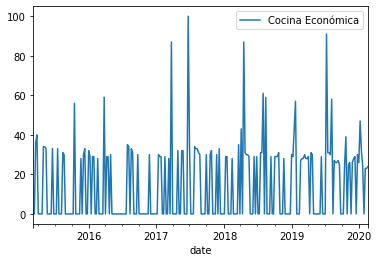

In [26]:
iot[0].plot()

### Con esto, tenemos parametrizado el interés en el estado por cada uno de los giros de comida.
### Ahora, necesitamos revisar el grado de satisfacción de los usuarios por la oferta existente.

# Yelp

### Utilizando la API de Yelp, hacemos búsquedas nuevamente sobre los diferentes giros de comida para encontrar negocios y sus calificaciónes en la plataforma.

In [27]:
import requests
from bs4 import BeautifulSoup as bs
import json

In [28]:
client_id = 'JPrLnyol5AaT0XLf7CYbWg'
api_key = '5F0kTJmEIUsrAXKEcpqHA_HvL2uKWA3HZC_iQ73dGgIXgke7fCh84CBP5KpwVMXumfm4BahGo3iaBiNtBi9Q9vexfphH6urta05XSFaaQCs6aphzSQfWwhWSo_6nXHYx'
app_name = 'ravenous'

endpoint = 'https://api.yelp.com/v3/businesses/search?'
req_parameters_1 = ['location']
req_parameters_2 = ['latitud', 'longitude']
optional_parameters = ['term', 'radius', 'categories', 'locale', 'limit', 'sort_by', 'price']

In [29]:
yelp_search = []
for comida in inegi_results:
    term = 'term={}&'.format(comida)
    print(term)
    location = 'latitude=21.073881&longitude=-89.655476&'
    locale = 'locale=es_MX&'
    radius = 'radius=3000&'
    limit = 'limit=50' 
    res = requests.get(endpoint+term+location+locale+radius+limit, headers={'Authorization':'Bearer '+api_key})
    soup = bs(res.content)
    yelp_json = json.loads(soup.findAll('p')[0].text)
    ydf = pd.DataFrame(yelp_json['businesses'])
    ydf['tipo'] = comida
    yelp_search.append(ydf)
    
yelp_search

term=Cocina Económica&
term=Antojitos&
term=Pizza&
term=Hamburguesas&
term=Hot Dogs&
term=Sushi&
term=Tamales&
term=Mariscos&
term=Pescado&
term=Tacos&
term=Carne&
term=Asada&
term=Panuchos&
term=Cochinita&
term=Pollo&
term=Desayunos&
term=Tortas&
term=Mondongo&
term=Empanadas&
term=Chicharronería&
term=Gorditas&
term=Costillas&
term=Grill&
term=Carnitas&
term=Doraditas&
term=Baguettes&
term=Parrilla&
term=Huaraches&
term=Rosticería&
term=China&
term=Yucateca&
term=Tabasqueña&
term=Arrachera&
term=Pastor&
term=Birria&
term=Barbacoa&
term=Pozole&


[Empty DataFrame
 Columns: [tipo]
 Index: [], Empty DataFrame
 Columns: [tipo]
 Index: [],                        id                                          alias  \
 0  39j8D_eznJbJ6_ERzhIWng                              bella-roma-mérida   
 1  DQVZmAV67SIPXOWcfbBfuQ  cafetería-facultad-de-matemáticas-uady-mérida   
 
                                      name  \
 0                              Bella Roma   
 1  Cafetería Facultad De Matemáticas UADY   
 
                                            image_url  is_closed  \
 0  https://s3-media2.fl.yelpcdn.com/bphoto/n5QXPh...      False   
 1  https://s3-media4.fl.yelpcdn.com/bphoto/Y_wxih...      False   
 
                                                  url  review_count  \
 0  https://www.yelp.com.mx/biz/bella-roma-m%C3%A9...             9   
 1  https://www.yelp.com.mx/biz/cafeter%C3%ADa-fac...             3   
 
                                           categories  rating  \
 0  [{'alias': 'italian', 'title': 'Cocina italian.

In [30]:
lugares = pd.concat(yelp_search, axis=0, sort=False)
print(lugares.shape)
lugares.reset_index(inplace=True)
lugares

(24, 17)


,index,tipo,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone,distance
0,0,Pizza,39j8D_eznJbJ6_ERzhIWng,bella-roma-mérida,Bella Roma,https://s3-media2.fl.yelpcdn.com/bphoto/n5QXPh...,False,https://www.yelp.com.mx/biz/bella-roma-m%C3%A9...,9.0,"[{'alias': 'italian', 'title': 'Cocina italian...",4.5,"{'latitude': 21.0716194744981, 'longitude': -8...",[],$$,"{'address1': 'Calle 57-B S/N', 'address2': '',...",+529992273837,01 999 227 3837,917.867454
1,1,Pizza,DQVZmAV67SIPXOWcfbBfuQ,cafetería-facultad-de-matemáticas-uady-mérida,Cafetería Facultad De Matemáticas UADY,https://s3-media4.fl.yelpcdn.com/bphoto/Y_wxih...,False,https://www.yelp.com.mx/biz/cafeter%C3%ADa-fac...,3.0,"[{'alias': 'delis', 'title': 'Tortas'}]",4.5,"{'latitude': 21.048168255592, 'longitude': -89...",[],NaN,"{'address1': 'Anillo Periferico Norte', 'addre...",,,3074.036996
2,0,Hamburguesas,vKSmXOhH2JcIcCCu5SoZzA,angry-angus-hamburguesas-mérida-2,Angry Angus Hamburguesas,https://s3-media2.fl.yelpcdn.com/bphoto/4SXq9M...,False,https://www.yelp.com.mx/biz/angry-angus-hambur...,22.0,"[{'alias': 'burgers', 'title': 'Hamburguesas'}]",4.0,"{'latitude': 21.0691342629407, 'longitude': -8...",[],$,"{'address1': 'Calle 59 718', 'address2': 'Col....",+529993165776,01 999 316 5776,877.738489
3,1,Hamburguesas,ih71mOReXxJ1ITWq0mg46g,burger-navy-mérida,Burger Navy,https://s3-media2.fl.yelpcdn.com/bphoto/EpTLH_...,False,https://www.yelp.com.mx/biz/burger-navy-m%C3%A...,3.0,"[{'alias': 'burgers', 'title': 'Hamburguesas'}]",3.5,"{'latitude': 21.0304604, 'longitude': -89.6354...",[],NaN,"{'address1': 'Av. 1 A Fovissste', 'address2': ...",,,2663.760936
4,0,Hot Dogs,vKSmXOhH2JcIcCCu5SoZzA,angry-angus-hamburguesas-mérida-2,Angry Angus Hamburguesas,https://s3-media2.fl.yelpcdn.com/bphoto/4SXq9M...,False,https://www.yelp.com.mx/biz/angry-angus-hambur...,22.0,"[{'alias': 'burgers', 'title': 'Hamburguesas'}]",4.0,"{'latitude': 21.0691342629407, 'longitude': -8...",[],$,"{'address1': 'Calle 59 718', 'address2': 'Col....",+529993165776,01 999 316 5776,877.738489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19,0,Doraditas,DQVZmAV67SIPXOWcfbBfuQ,cafetería-facultad-de-matemáticas-uady-mérida,Cafetería Facultad De Matemáticas UADY,https://s3-media4.fl.yelpcdn.com/bphoto/Y_wxih...,False,https://www.yelp.com.mx/biz/cafeter%C3%ADa-fac...,3.0,"[{'alias': 'delis', 'title': 'Tortas'}]",4.5,"{'latitude': 21.048168255592, 'longitude': -89...",[],NaN,"{'address1': 'Anillo Periferico Norte', 'addre...",,,3074.036996
20,0,Parrilla,Vn-iU80DUPjhX2fxYg2Kzg,finca-grill-mérida,Finca Grill,https://s3-media2.fl.yelpcdn.com/bphoto/2BvNoW...,False,https://www.yelp.com.mx/biz/finca-grill-m%C3%A...,1.0,"[{'alias': 'steak', 'title': 'Parrilla'}]",5.0,"{'latitude': 21.0696489457516, 'longitude': -8...",[],NaN,"{'address1': 'Calle 100', 'address2': '', 'add...",,,476.965563
21,0,Arrachera,vKSmXOhH2JcIcCCu5SoZzA,angry-angus-hamburguesas-mérida-2,Angry Angus Hamburguesas,https://s3-media2.fl.yelpcdn.com/bphoto/4SXq9M...,False,https://www.yelp.com.mx/biz/angry-angus-hambur...,22.0,"[{'alias': 'burgers', 'title': 'Hamburguesas'}]",4.0,"{'latitude': 21.0691342629407, 'longitude': -8...",[],$,"{'address1': 'Calle 59 718', 'address2': 'Col....",+529993165776,01 999 316 5776,877.738489
22,1,Arrachera,kVNGwAwtPlupStrd0nAp4w,salamanca-bar-y-grill-mérida,Salamanca Bar & Grill,https://s3-media2.fl.yelpcdn.com/bphoto/IR6OYG...,False,https://www.yelp.com.mx/biz/salamanca-bar-y-gr...,4.0,"[{'alias': 'argentine', 'title': 'Cocina argen...",5.0,"{'latitude': 21.0576879626933, 'longitude': -8...",[],$$,"{'address1': '', 'address2': '', 'address3': '...",,,2183.682732


In [31]:
lugares.tipo.value_counts()

Carne           4
Tortas          2
Arrachera       2
Pizza           2
Hamburguesas    2
Grill           2
Hot Dogs        2
Doraditas       1
Tacos           1
Sushi           1
Desayunos       1
Asada           1
Pastor          1
Parrilla        1
Empanadas       1
Name: tipo, dtype: int64

In [32]:
#lugares.reset_index(inplace=True)

### La información más relevante que extraemos de Yelp es el 'rating' por giro de comida, por lo que de los resultados sacamos promedios basados en su giro.

In [33]:
ratings = dict(lugares.tipo.value_counts())
for comida in inegi_results:
    ratings[comida] = lugares[lugares.tipo == comida]['rating'].mean()
ratings

{'Carne': 4.625,
 'Tortas': 4.0,
 'Arrachera': 4.5,
 'Pizza': 4.5,
 'Hamburguesas': 3.75,
 'Grill': 5.0,
 'Hot Dogs': 3.75,
 'Doraditas': 4.5,
 'Tacos': 4.0,
 'Sushi': 4.0,
 'Desayunos': 3.5,
 'Asada': 5.0,
 'Pastor': 4.0,
 'Parrilla': 5.0,
 'Empanadas': 4.5,
 'Cocina Económica': nan,
 'Antojitos': nan,
 'Tamales': nan,
 'Mariscos': nan,
 'Pescado': nan,
 'Panuchos': nan,
 'Cochinita': nan,
 'Pollo': nan,
 'Mondongo': nan,
 'Chicharronería': nan,
 'Gorditas': nan,
 'Costillas': nan,
 'Carnitas': nan,
 'Baguettes': nan,
 'Huaraches': nan,
 'Rosticería': nan,
 'China': nan,
 'Yucateca': nan,
 'Tabasqueña': nan,
 'Birria': nan,
 'Barbacoa': nan,
 'Pozole': nan}

In [34]:
yf = pd.concat(yelp_search)
yf.drop(columns = ['alias', 'display_phone', 'location', 'id', 'image_url', 'is_closed', 'phone', 'transactions', 'url'], inplace=True)
yf.reset_index(inplace=True)
yf.head()

/home/linuxbrew/.linuxbrew/Cellar/jupyterlab/1.2.4/libexec/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,index,categories,coordinates,distance,name,price,rating,review_count,tipo
0,0,"[{'alias': 'italian', 'title': 'Cocina italian...","{'latitude': 21.0716194744981, 'longitude': -8...",917.867454,Bella Roma,$$,4.5,9.0,Pizza
1,1,"[{'alias': 'delis', 'title': 'Tortas'}]","{'latitude': 21.048168255592, 'longitude': -89...",3074.036996,Cafetería Facultad De Matemáticas UADY,NaN,4.5,3.0,Pizza
2,0,"[{'alias': 'burgers', 'title': 'Hamburguesas'}]","{'latitude': 21.0691342629407, 'longitude': -8...",877.738489,Angry Angus Hamburguesas,$,4.0,22.0,Hamburguesas
3,1,"[{'alias': 'burgers', 'title': 'Hamburguesas'}]","{'latitude': 21.0304604, 'longitude': -89.6354...",2663.760936,Burger Navy,NaN,3.5,3.0,Hamburguesas
4,0,"[{'alias': 'burgers', 'title': 'Hamburguesas'}]","{'latitude': 21.0691342629407, 'longitude': -8...",877.738489,Angry Angus Hamburguesas,$,4.0,22.0,Hot Dogs


In [35]:
df['YelpRating'] = yf.groupby('tipo').mean().rating
df

,InegiCount,GoogleTrend,YelpRating
Index,,,
Cocina Económica,1409,100,NaN
Antojitos,1030,39,NaN
Pizza,309,100,4.50
Hamburguesas,149,51,3.75
Hot Dogs,36,24,3.75
...,...,...,...
Arrachera,4,44,4.50
Pastor,22,91,4.00
Birria,3,15,NaN


## Yelp Locations Dataframe

In [36]:
from pandas.io.json import json_normalize
yf.head()

,index,categories,coordinates,distance,name,price,rating,review_count,tipo
0,0,"[{'alias': 'italian', 'title': 'Cocina italian...","{'latitude': 21.0716194744981, 'longitude': -8...",917.867454,Bella Roma,$$,4.5,9.0,Pizza
1,1,"[{'alias': 'delis', 'title': 'Tortas'}]","{'latitude': 21.048168255592, 'longitude': -89...",3074.036996,Cafetería Facultad De Matemáticas UADY,NaN,4.5,3.0,Pizza
2,0,"[{'alias': 'burgers', 'title': 'Hamburguesas'}]","{'latitude': 21.0691342629407, 'longitude': -8...",877.738489,Angry Angus Hamburguesas,$,4.0,22.0,Hamburguesas
3,1,"[{'alias': 'burgers', 'title': 'Hamburguesas'}]","{'latitude': 21.0304604, 'longitude': -89.6354...",2663.760936,Burger Navy,NaN,3.5,3.0,Hamburguesas
4,0,"[{'alias': 'burgers', 'title': 'Hamburguesas'}]","{'latitude': 21.0691342629407, 'longitude': -8...",877.738489,Angry Angus Hamburguesas,$,4.0,22.0,Hot Dogs


In [37]:
json_normalize(yf.coordinates)

,latitude,longitude
0,21.071619,-89.646968
1,21.048168,-89.644594
2,21.069134,-89.648717
3,21.030460,-89.635452
4,21.069134,-89.648717
...,...,...
19,21.048168,-89.644594
20,21.069649,-89.656226
21,21.069134,-89.648717
22,21.057688,-89.643569


In [38]:
#yf.reset_index()
yf[['latitude', 'longitude']] = json_normalize(yf.coordinates)
#yf.drop(columns=['coordinates'], inplace=True)
yf.head()

,index,categories,coordinates,distance,name,price,rating,review_count,tipo,latitude,longitude
0,0,"[{'alias': 'italian', 'title': 'Cocina italian...","{'latitude': 21.0716194744981, 'longitude': -8...",917.867454,Bella Roma,$$,4.5,9.0,Pizza,21.071619,-89.646968
1,1,"[{'alias': 'delis', 'title': 'Tortas'}]","{'latitude': 21.048168255592, 'longitude': -89...",3074.036996,Cafetería Facultad De Matemáticas UADY,NaN,4.5,3.0,Pizza,21.048168,-89.644594
2,0,"[{'alias': 'burgers', 'title': 'Hamburguesas'}]","{'latitude': 21.0691342629407, 'longitude': -8...",877.738489,Angry Angus Hamburguesas,$,4.0,22.0,Hamburguesas,21.069134,-89.648717
3,1,"[{'alias': 'burgers', 'title': 'Hamburguesas'}]","{'latitude': 21.0304604, 'longitude': -89.6354...",2663.760936,Burger Navy,NaN,3.5,3.0,Hamburguesas,21.030460,-89.635452
4,0,"[{'alias': 'burgers', 'title': 'Hamburguesas'}]","{'latitude': 21.0691342629407, 'longitude': -8...",877.738489,Angry Angus Hamburguesas,$,4.0,22.0,Hot Dogs,21.069134,-89.648717


In [39]:
yf[yf.tipo=='Arrachera']

,index,categories,coordinates,distance,name,price,rating,review_count,tipo,latitude,longitude
21,0,"[{'alias': 'burgers', 'title': 'Hamburguesas'}]","{'latitude': 21.0691342629407, 'longitude': -8...",877.738489,Angry Angus Hamburguesas,$,4.0,22.0,Arrachera,21.069134,-89.648717
22,1,"[{'alias': 'argentine', 'title': 'Cocina argen...","{'latitude': 21.0576879626933, 'longitude': -8...",2183.682732,Salamanca Bar & Grill,$$,5.0,4.0,Arrachera,21.057688,-89.643569


In [40]:
df['score'] = df.GoogleTrend/100 - df.YelpRating/5 - df.InegiCount/df.InegiCount.max()
df.sort_values(by='score', ascending=False)

,InegiCount,GoogleTrend,YelpRating,score
Index,,,,
Pastor,22,91,4.0,0.094386
Doraditas,23,100,4.5,0.083676
Desayunos,89,81,3.5,0.046835
Parrilla,20,100,5.0,-0.014194
Pizza,309,100,4.5,-0.119304
...,...,...,...,...
Yucateca,48,100,NaN,NaN
Tabasqueña,13,12,NaN,NaN
Birria,3,15,NaN,NaN


In [59]:
top_types = df.sort_values(by='score', ascending=False).head().index

top_yf_locs = {}
for top in top_types:
    print(top)
    print(yf[yf.tipo==top][['latitude', 'longitude']])
    top_yf_locs[top] = yf[yf.tipo==top][['latitude', 'longitude']].head().values
    
top_yf_locs

Pastor
    latitude  longitude
23  21.07453 -89.631094
Doraditas
     latitude  longitude
19  21.048168 -89.644594
Desayunos
     latitude  longitude
13  21.062864 -89.632097
Parrilla
     latitude  longitude
20  21.069649 -89.656226
Pizza
    latitude  longitude
0  21.071619 -89.646968
1  21.048168 -89.644594


{'Pastor': array([[ 21.07453018, -89.63109407]]),
 'Doraditas': array([[ 21.04816826, -89.64459381]]),
 'Desayunos': array([[ 21.06286383, -89.63209715]]),
 'Parrilla': array([[ 21.06964895, -89.65622553]]),
 'Pizza': array([[ 21.07161947, -89.64696829],
        [ 21.04816826, -89.64459381]])}

In [72]:
top_yf = pd.DataFrame(columns = yf.columns)
for top in top_types:
    print(top)
    #print(yf[yf.tipo==top])
    top_yf = pd.concat([top_yf, yf[yf.tipo==top]])
    
top_yf

Pastor
Doraditas
Desayunos
Parrilla
Pizza


,index,categories,coordinates,distance,name,price,rating,review_count,tipo,latitude,longitude
23,0,"[{'alias': 'tacos', 'title': 'Taquerías'}]","{'latitude': 21.0745301789431, 'longitude': -8...",2530.840069,Tacos Al Pastor Xavi,NaN,4.0,2.0,Pastor,21.074530,-89.631094
19,0,"[{'alias': 'delis', 'title': 'Tortas'}]","{'latitude': 21.048168255592, 'longitude': -89...",3074.036996,Cafetería Facultad De Matemáticas UADY,NaN,4.5,3.0,Doraditas,21.048168,-89.644594
13,0,"[{'alias': 'breakfast_brunch', 'title': 'Desay...","{'latitude': 21.0628638335427, 'longitude': -8...",2717.608570,Los Benes House,$$$,3.5,2.0,Desayunos,21.062864,-89.632097
20,0,"[{'alias': 'steak', 'title': 'Parrilla'}]","{'latitude': 21.0696489457516, 'longitude': -8...",476.965563,Finca Grill,NaN,5.0,1.0,Parrilla,21.069649,-89.656226
0,0,"[{'alias': 'italian', 'title': 'Cocina italian...","{'latitude': 21.0716194744981, 'longitude': -8...",917.867454,Bella Roma,$$,4.5,9.0,Pizza,21.071619,-89.646968
1,1,"[{'alias': 'delis', 'title': 'Tortas'}]","{'latitude': 21.048168255592, 'longitude': -89...",3074.036996,Cafetería Facultad De Matemáticas UADY,NaN,4.5,3.0,Pizza,21.048168,-89.644594


,index,categories,coordinates,distance,name,price,rating,review_count,tipo,latitude,longitude
0,0,"[{'alias': 'italian', 'title': 'Cocina italian...","{'latitude': 21.0716194744981, 'longitude': -8...",917.867454,Bella Roma,$$,4.5,9.0,Pizza,21.071619,-89.646968
1,1,"[{'alias': 'delis', 'title': 'Tortas'}]","{'latitude': 21.048168255592, 'longitude': -89...",3074.036996,Cafetería Facultad De Matemáticas UADY,NaN,4.5,3.0,Pizza,21.048168,-89.644594


# Foursquare

In [42]:
import foursquare

client = foursquare.Foursquare(client_id='HVOBXQ5NMUK2AZBCBRSXIBBIFTI1PXKYYMXL2ZG0CIPOTULA', client_secret='BIKGFRQS2FVUM0VN51R5FMIGCRTUYG31BU5IW24CBHSSDNIO')

In [43]:
fs_results = {}
for comida in top_yf_locs.keys():
    print(comida)
    fs_results[comida] = client.venues.search(params={'query': comida, 'intent':'checkin', 'll': '21.073881,-89.655476', 'radius':3000, 'limit':10})
    
fs_results

Pastor
Doraditas
Desayunos
Parrilla
Pizza


{'Pastor': {'venues': [{'id': '5afb6ceed807ee002cf2115a',
    'name': 'Pastor Maya',
    'location': {'address': 'Calle 59',
     'lat': 21.069036,
     'lng': -89.647514,
     'labeledLatLngs': [{'label': 'display',
       'lat': 21.069036,
       'lng': -89.647514}],
     'distance': 987,
     'cc': 'MX',
     'city': 'Mérida',
     'state': 'Yucatán',
     'country': 'México',
     'formattedAddress': ['Calle 59', 'Mérida, Yucatán', 'México']},
    'categories': [{'id': '5744ccdfe4b0c0459246b4d3',
      'name': 'Yucatecan Restaurant',
      'pluralName': 'Yucatecan Restaurants',
      'shortName': 'Yucatecan',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/mexican_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1583166103',
    'hasPerk': False}]},
 'Doraditas': {'venues': [{'id': '51a28bf2498eae4ec446be41',
    'name': 'Las Doraditas De Las Americas',
    'location': {'address': 'Calle 74',
     'crossStreet': 'Por 59j',
     'lat':

In [44]:
fs_locs = {}
for result in fs_results:
    result_locs = []
    for i in range(len(fs_results[result]['venues'])):
        loc = []
        loc.append(fs_results[result]['venues'][i]['location']['lat'])
        loc.append(fs_results[result]['venues'][i]['location']['lng'])
        result_locs.append(loc)
    fs_locs[result] = result_locs
    
fs_locs

{'Pastor': [[21.069036, -89.647514]],
 'Doraditas': [[21.063982978119167, -89.64472992976738]],
 'Desayunos': [],
 'Parrilla': [],
 'Pizza': [[21.072228103630664, -89.65542665465934],
  [21.078077, -89.655911],
  [21.07757262145833, -89.65628564357758],
  [21.069292, -89.656364],
  [21.067967, -89.644076],
  [21.068066, -89.644264],
  [21.066053867501815, -89.64446339336273],
  [21.064085, -89.64439],
  [21.089666, -89.635986],
  [21.047847817354043, -89.64023456826065]]}

In [45]:
fs_locs = {}
for result in fs_results:
    result_locs = []
    for i in range(len(fs_results[result]['venues'])):
        loc = {}
        loc[fs_results[result]['venues'][i]['name']] = []
        loc[fs_results[result]['venues'][i]['name']].append(fs_results[result]['venues'][i]['location']['lat'])
        loc[fs_results[result]['venues'][i]['name']].append(fs_results[result]['venues'][i]['location']['lng'])
        result_locs.append(loc)
    fs_locs[result] = result_locs
    
fs_locs

{'Pastor': [{'Pastor Maya': [21.069036, -89.647514]}],
 'Doraditas': [{'Las Doraditas De Las Americas': [21.063982978119167,
    -89.64472992976738]}],
 'Desayunos': [],
 'Parrilla': [],
 'Pizza': [{'Pizza Ready': [21.072228103630664, -89.65542665465934]},
  {'Pizza Inn': [21.078077, -89.655911]},
  {'Barelli Pizza': [21.07757262145833, -89.65628564357758]},
  {"Domino's Pizza": [21.069292, -89.656364]},
  {'Little Caesars Pizza': [21.067967, -89.644076]},
  {"Little Caesar's Pizza": [21.068066, -89.644264]},
  {'Dolce Pizza': [21.066053867501815, -89.64446339336273]},
  {'Casera Pizza Las Americas': [21.064085, -89.64439]},
  {"Capo's pizza & pasta bar": [21.089666, -89.635986]},
  {'Vía 3 Pizza': [21.047847817354043, -89.64023456826065]}]}

## Folium map

In [92]:
import folium

In [94]:
import folium

mapa=folium.Map(location=[21.073881,-89.655476], tiles='openstreetmap',zoom_start=12)

five_colors = ['red', 'orange', 'lightgreen', 'green', 'blue']
colors = dict(zip(fs_locs.keys(),five_colors))

folium.Circle([21.073881,-89.655476], radius=3000, icon=folium.Icon()).add_to(mapa)

for i in top_yf.index:
    folium.Marker(list(top_yf.loc[i][['latitude', 'longitude']]), popup='<b>'+top_yf.loc[i]['name']+'</b>', tooltip=top_yf.loc[i]['tipo'], icon=folium.Icon(color=colors[top_yf.loc[i]['tipo']], icon='info-sign')).add_to(mapa)

for key in top_types:
    for loc in fs_locs[key]:
        name = list(loc.keys())[0]
        folium.Marker(list(loc[name]), popup='<b>'+ name +'</b>', tooltip=key, icon=folium.Icon(color=colors[key], icon='info-sign')).add_to(mapa)

mapa